In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(affycoretools)
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(ggpubr)
library(fgsea)
library(clusterProfiler)
library(org.Hs.eg.db)
require(dplyr)
require(stringr)

# project directories, and libraries loaded and saving total number of patients

MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v3.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))

num_pat_tot = length(MM_patients[2,])
num_cell_line_tot = length(MM_cell_line[2,])

# checking total number of patients and cell lines and output head

head(MM_cell_line)
head(MM_patients)
print(num_pat_tot)
print(num_cell_line_tot)

Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

Sample,GENE_NAME,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,2,0,100,2,0,0,2,88,⋯,2,0,0,0,0,0,0,0,2,114
ENSG00000000005,TNMD,1,0,0,0,1,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000000419,DPM1,3949,4134,4795,8278,2262,2587,3607,2450,⋯,2694,1247,3263,3044,3108,4538,7336,4430,9279,13828
ENSG00000000457,SCYL3,1597,1513,2412,1988,1530,926,1415,573,⋯,665,994,497,1611,1603,1375,1426,893,1540,1660
ENSG00000000460,C1orf112,3072,1488,2193,4091,3208,1170,3614,1618,⋯,1472,1517,1346,2068,3128,1850,2522,2320,793,689
ENSG00000000938,FGR,0,22,701,5,2,4,89,4,⋯,0,125,777,50,1890,2315,1514,5,3776,847


GENE_ID,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,17,999,85,9,801,20,12,16,4,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,2,3,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,1495,3271,2303,1234,1896,4400,2013,1745,1698,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,231,809,203,1208,425,2793,710,922,853,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,87,319,31,183,85,929,174,292,837,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,318,105,119,190,2064,2952,12,351,498,⋯,46,14,303,2007,58,77,1037,11,174,22


[1] 893
[1] 68


In [2]:
# finding genes in common and creating character vector of Ensembl Gene IDs

ensembl_intersect = intersect(MM_cell_line$Sample, MM_patients$GENE_ID)

# assigning rownames as ensembl gene IDs so as to be able to parse by ensembl Gene IDs

rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID

# removing gene ID and gene name columns 
# and saving them in a separate place 
# note only those available in MM_cell_line
# also filtering out genes in common
# and fusing them into a single dataframe
# and filtering for only newly diagnosed patients
# to be kept in a separate data frame

ensembl_ids = MM_cell_line[,1]
MM_cell_line = MM_cell_line[, -1]
gene_names = MM_cell_line[,1]
gene_info = cbind(ensembl_ids, gene_names)

MM_cell_line = MM_cell_line[,-1]
MM_cell_line = MM_cell_line[ensembl_intersect, ]
MM_patients = MM_patients[ensembl_intersect, -1]

MM_patient_ids = data.frame(colnames(MM_patients))
MM_patients_new = filter(MM_patient_ids, str_extract(MM_patient_ids[,1], "_[0-9]_") == "_1_")
keepc = colnames(MM_patients) %in% MM_patients_new[,1]
MM_patients_nd = MM_patients[,keepc]

MM_combined = cbind(MM_cell_line, MM_patients)

# checking output head to confirm removal

head(MM_cell_line)
head(MM_patients)
head(MM_combined)
head(gene_info)

# saving number of newly diagnosed patients and printing out percentage

num_new_pat = length(MM_patients_nd[2,])
print(num_new_pat)
print((num_new_pat/num_pat_tot)*100)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,0,0,0,0,0,0,0,2,114
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2694,1247,3263,3044,3108,4538,7336,4430,9279,13828
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,665,994,497,1611,1603,1375,1426,893,1540,1660
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,1472,1517,1346,2068,3128,1850,2522,2320,793,689
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,0,125,777,50,1890,2315,1514,5,3776,847


,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,MMRF_2341_1_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,17,999,85,9,801,20,12,16,4,43,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,2,3,0,0,0,0,1,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,1495,3271,2303,1234,1896,4400,2013,1745,1698,2403,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,231,809,203,1208,425,2793,710,922,853,1203,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,87,319,31,183,85,929,174,292,837,478,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,318,105,119,190,2064,2952,12,351,498,555,⋯,46,14,303,2007,58,77,1037,11,174,22


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,46,14,303,2007,58,77,1037,11,174,22


ensembl_ids,gene_names
ENSG00000000003,TSPAN6
ENSG00000000005,TNMD
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,C1orf112
ENSG00000000938,FGR


[1] 779
[1] 87.23404


In [3]:
# transforming counts of cell_line, patients, and combined 
# to account for sequencing depth
# and creating boolean vector of those genes that
# holds TRUE for genes that account for greater than a millionth
# of total mapped reads in 2 or more samples
# then filtering MM_combined based on this vector
# aka filtering out low count genes

MM_combined_cpm = cpm(MM_combined)
keep = rowSums(MM_combined_cpm > 1) > 2
MM_combined.filtered = MM_combined[keep, ]
MM_patients = MM_patients[keep, ]
MM_cell_line = MM_cell_line[keep, ]

# checking output head and number of low count genes remaining after filtering

head(keep)
head(MM_combined.filtered)
sum(keep)

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
           TRUE           FALSE            TRUE            TRUE            TRUE 
ENSG00000000938 
           TRUE

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,46,14,303,2007,58,77,1037,11,174,22
ENSG00000000971,11,207,24,21,18,8,685,12,28,2,⋯,13,5,28,118,30,18,1865,1680,56,10


[1] 22677

In [4]:
# normalizing combined data frames with vst

norm_combined = vst(as.matrix(MM_combined.filtered))

# checking output head

head(norm_combined)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000419,11.203503,11.074854,11.494757,11.915436,10.309063,10.999754,11.088513,11.014313,10.141935,11.745230,⋯,11.193842,10.433799,8.751681,12.055311,11.140925,11.779415,10.405654,10.644307,10.820096,10.844967
ENSG00000000457,9.931440,9.668281,10.522303,9.902041,9.765565,9.564948,9.777196,9.002211,9.705423,10.347211,⋯,9.503770,9.740347,8.712015,9.055347,7.830135,9.211329,9.518367,9.494629,9.623449,10.069578
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621


In [5]:
# separating out patient and cell line columns from norm_combined

norm_pat = norm_combined[,colnames(MM_patients)]
norm_cell = norm_combined[,colnames(MM_cell_line)]
norm_pat_nd = norm_combined[,colnames(MM_patients_nd)]

# checking output head

head(norm_pat)
head(norm_cell)
head(norm_pat_nd)

,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,MMRF_2341_1_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.763143,9.537185,7.395753,5.308595,9.830803,5.274120,5.550078,5.500219,4.872554,5.880590,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000419,10.974725,11.195989,11.818120,10.507028,11.038501,11.074396,11.418836,10.688833,10.510092,10.569849,⋯,11.193842,10.433799,8.751681,12.055311,11.140925,11.779415,10.405654,10.644307,10.820096,10.844967
ENSG00000000457,8.420720,9.249930,8.461872,10.477123,8.968302,10.433395,9.951931,9.797906,9.553685,9.607254,⋯,9.503770,9.740347,8.712015,9.055347,7.830135,9.211329,9.518367,9.494629,9.623449,10.069578
ENSG00000000460,7.240012,8.035522,6.362907,7.950493,7.004830,8.922297,8.080643,8.263642,9.527754,8.376546,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,8.838641,6.773748,7.792299,7.996890,11.158836,10.511120,5.550078,8.499929,8.827716,8.569701,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,8.954700,9.660588,9.272141,7.626551,8.452307,12.823135,5.732564,8.006766,9.272567,5.736415,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.707500,4.277689,4.277689,4.277689,4.277689,4.277689,4.277689,4.277689,4.628974,6.456153
ENSG00000000419,11.203503,11.074854,11.494757,11.915436,10.309063,10.999754,11.088513,11.014313,10.141935,11.745230,⋯,11.213561,10.093941,11.352302,10.930239,10.590877,11.140197,11.955852,11.043716,12.398838,12.666907
ENSG00000000457,9.931440,9.668281,10.522303,9.902041,9.765565,9.564948,9.777196,9.002211,9.705423,10.347211,⋯,9.264065,9.779521,8.749033,10.037164,9.668741,9.472541,9.649261,8.832004,9.858348,9.669506
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,10.360803,10.367704,10.104580,10.385818,10.599902,9.880745,10.441824,10.134136,8.954919,8.491219
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,4.277689,7.148103,9.347799,6.008208,9.896101,10.192478,9.731689,4.776205,11.116661,8.761160
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,7.084740,5.339650,6.334592,4.643934,6.922797,5.655105,6.618223,8.390881,7.857338,7.031385


,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2341_1_BM,MMRF_2501_1_BM,MMRF_1383_1_BM,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.763143,9.537185,7.395753,5.308595,9.830803,5.550078,5.500219,5.880590,8.990467,10.083930,⋯,4.645601,6.735236,4.724323,7.872087,7.279442,8.268661,5.786579,4.906192,5.573125,5.539938
ENSG00000000419,10.974725,11.195989,11.818120,10.507028,11.038501,11.418836,10.688833,10.569849,10.552441,10.558826,⋯,11.141672,11.864629,11.193842,10.433799,8.751681,11.140925,11.779415,10.644307,10.820096,10.844967
ENSG00000000457,8.420720,9.249930,8.461872,10.477123,8.968302,9.951931,9.797906,9.607254,9.902931,9.853540,⋯,9.373885,8.482865,9.503770,9.740347,8.712015,7.830135,9.211329,9.494629,9.623449,10.069578
ENSG00000000460,7.240012,8.035522,6.362907,7.950493,7.004830,8.080643,8.263642,8.376546,7.712189,7.633277,⋯,7.396229,6.755457,8.168128,7.194023,7.405635,6.115524,6.992802,7.733282,7.793913,7.505658
ENSG00000000938,8.838641,6.773748,7.792299,7.996890,11.158836,5.550078,8.499929,8.569701,5.955129,6.015730,⋯,11.938327,6.672686,6.266877,5.502307,8.612095,7.314219,7.142771,5.457562,7.633019,6.535104
ENSG00000000971,8.954700,9.660588,9.272141,7.626551,8.452307,5.732564,8.006766,5.736415,6.367379,5.769675,⋯,11.685182,6.187998,5.392960,5.023380,6.038515,6.621261,5.826595,11.058560,6.433822,5.876621


In [6]:
# utilizing IQR to get vector of top 5000 and top 10000 genes
# for all and newly diagnosed separately

keepi = apply(norm_pat, 1, IQR)
keepis = sort(keepi, decreasing = TRUE)
keepi5000 = keepi %in% keepis[1:5000]
keepi10000 = keepi %in% keepis[1:10000]

In [7]:
# making function for doing correlation analysis and generating violin plots

makeplots = function(corset, pnames, clnames, titl) {
    
    MM.cor.v = cor(corset, method = "s")

    #clnames = colnames(MM_cell_line)
    tumor_cell_all = data.frame()

    for(patients in pnames){
        cell_line_tumor_cor = MM.cor.v[patients, clnames]
        cell_line_tumor_cor = data.frame(patient = patients, 
                                         sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
        tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
    }

    cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
    cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
    tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

      p <- ggplot(tumor_cell_all, aes(sample, cor))
      print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + ylab('R') +
              xlab("") + labs(title = titl) +
              stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", 
                           fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  
            theme(panel.background = element_rect(color = 'white'), 
                  axis.text.x = element_text(angle = 70, hjust = 1, size=8))# + stat_compare_means()
      )
   # return(cell_line_order)
}

In [8]:
# subsetting top 5000 / 10000 genes for all patients,

norm_combined_5 = norm_combined[keepi5000,]
norm_combined_10 = norm_combined[keepi10000,]

# checking output head

head(norm_combined_5)
head(norm_combined_10)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621
ENSG00000001561,11.299764,11.117408,10.699169,9.186855,8.748253,10.206546,11.290563,9.731783,10.226765,9.290325,⋯,12.204722,9.798182,7.611145,10.935838,8.829046,10.531100,10.341254,10.757729,10.380698,10.913626
ENSG00000002586,9.380980,6.053948,7.358972,5.070450,10.986954,4.565888,6.487835,4.791415,11.911219,4.744915,⋯,6.041618,6.413483,7.000104,9.279818,8.572020,14.222973,7.211198,6.001932,6.240530,8.344365


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621
ENSG00000001036,7.000852,10.211069,11.720964,11.135435,11.981179,10.888896,12.285082,11.033829,10.532772,11.783527,⋯,12.260334,9.971185,9.404070,11.306221,11.451127,12.650701,10.817835,10.819745,9.417302,10.881722
ENSG00000001460,6.375282,7.362978,8.140026,6.693884,6.926282,8.792218,7.409434,8.374054,7.762386,8.781882,⋯,7.110550,8.295360,6.986582,7.937612,6.653137,7.514923,7.170436,7.250312,7.388043,7.060976


In [9]:
# saving correlation tables for all patients,for top 5000 and 10000 most variable genes

MM.cor.keats_5 = cor(norm_combined_5, method = "s")
MM.cor.keats_5 = MM.cor.keats_5[colnames(MM_patients), colnames(MM_cell_line)]

MM.cor.keats_10 = cor(norm_combined_10, method = "s")
MM.cor.keats_10 = MM.cor.keats_10[colnames(MM_patients), colnames(MM_cell_line)]

# checking output head

head(MM.cor.keats_5)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
MMRF_2801_1_BM,0.4517749,0.4349749,0.4286582,0.4822847,0.4359017,0.3972648,0.3971391,0.4149805,0.4233515,0.3452179,⋯,0.4516974,0.3766863,0.4153700,0.3859249,0.3398826,0.4064589,0.3891746,0.3850782,0.3819718,0.3817107
MMRF_2718_1_BM,0.4581244,0.4431644,0.4038416,0.4653616,0.3949765,0.3453951,0.3860945,0.4110975,0.4140186,0.3285472,⋯,0.4205938,0.3508619,0.3986400,0.3644461,0.3750175,0.3829601,0.3748100,0.3510870,0.3648719,0.3567384
MMRF_2815_1_BM,0.4868771,0.4787737,0.4393861,0.4982120,0.4016501,0.3848549,0.4512338,0.4185613,0.4220763,0.3497691,⋯,0.4289724,0.3936808,0.4322049,0.3792175,0.4420574,0.4152898,0.4072691,0.3801919,0.4053549,0.4719518
MMRF_1656_1_BM,0.5550829,0.5661903,0.5050889,0.5649782,0.4854856,0.4713307,0.5534437,0.4912024,0.5269389,0.4215398,⋯,0.4850777,0.4525768,0.5089535,0.4544614,0.4610639,0.5070892,0.4952512,0.5039261,0.5325579,0.5265956
MMRF_2461_1_BM,0.4130272,0.4097795,0.3883913,0.4387081,0.3858632,0.3390691,0.3917873,0.3618470,0.3893378,0.2929299,⋯,0.3805764,0.2939174,0.3382522,0.3363116,0.2933794,0.3530543,0.3509824,0.3355592,0.3888328,0.3784962
MMRF_2531_2_PB,0.5867580,0.6231016,0.5915989,0.6099328,0.5379066,0.4859530,0.6272871,0.5618400,0.5438244,0.4738110,⋯,0.5375639,0.5169209,0.5658505,0.5283888,0.5861316,0.5713569,0.5726294,0.5650216,0.5306605,0.6052676


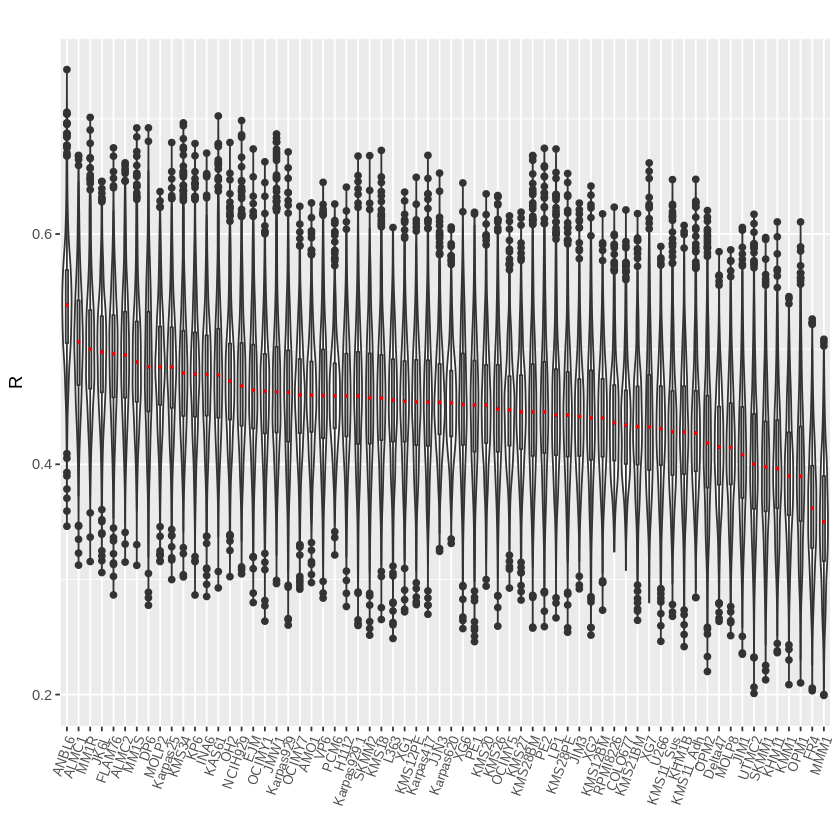

In [10]:
# subsetting for newly diagnosed patients 

norm_combined_5_nd = cbind(norm_combined_5[,colnames(MM_cell_line)], 
                           norm_combined_5[,colnames(MM_patients_nd)])

# plots for main analysis using top 5000 genes

makeplots(norm_combined_5_nd, colnames(MM_patients_nd), colnames(MM_cell_line), '')

,cor,type,rank
,<dbl>,<chr>,<int>
ALMC1,0.5066608,5000 Most Variable Genes,2
ALMC2,0.4967268,5000 Most Variable Genes,4
AMO1,0.4595980,5000 Most Variable Genes,26
ANBL6,0.5379676,5000 Most Variable Genes,1
COLO677,0.4367230,5000 Most Variable Genes,50
Delta47,0.4158869,5000 Most Variable Genes,58


,cor,type,rank
,<dbl>,<chr>,<int>
ALMC1,0.6973418,10000 Most Variable Genes,2
ALMC2,0.6928485,10000 Most Variable Genes,4
AMO1,0.6586324,10000 Most Variable Genes,32
ANBL6,0.7163193,10000 Most Variable Genes,1
COLO677,0.6363937,10000 Most Variable Genes,53
Delta47,0.6265948,10000 Most Variable Genes,58


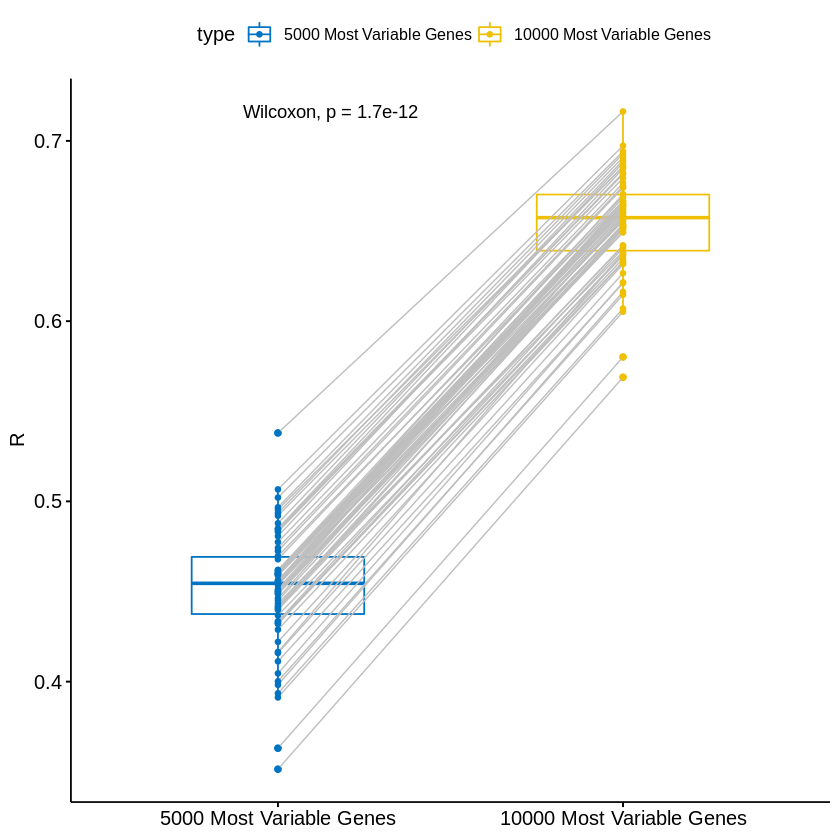

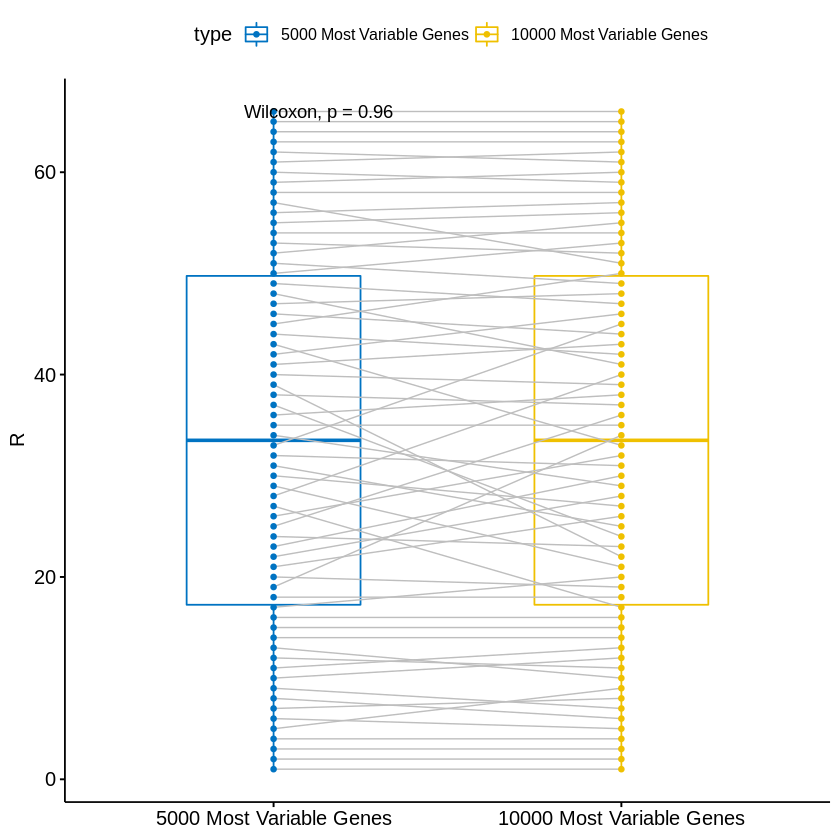

In [11]:
# creating vector of 1:number of cell lines for assigning rank

rank_gen = c(1:length(colnames(MM_cell_line)))

# getting patient correlate means for each cell lines, then assigning rank and type 
# for top 5 and 10 thousand most varuable genes

MM.cor.keats_5_nd = MM.cor.keats_5[colnames(MM_patients_nd),]
MM.cor.keats_5_nd_means = data.frame(colMeans(MM.cor.keats_5_nd))
MM.cor.keats_5_nd_means_ranks = MM.cor.keats_5_nd_means
MM.cor.keats_5_nd_means_ranks$type = '5000 Most Variable Genes'
colnames(MM.cor.keats_5_nd_means_ranks) = c('cor', 'type')
MM.cor.keats_5_nd_means_ranks = MM.cor.keats_5_nd_means_ranks[order(-MM.cor.keats_5_nd_means_ranks$cor),]
MM.cor.keats_5_nd_means_ranks$rank = rank_gen
MM.cor.keats_5_nd_means_ranks = MM.cor.keats_5_nd_means_ranks[order(rownames(MM.cor.keats_5_nd_means_ranks)),]

MM.cor.keats_10_nd = MM.cor.keats_10[colnames(MM_patients_nd),]
MM.cor.keats_10_nd_means = data.frame(colMeans(MM.cor.keats_10_nd))
MM.cor.keats_10_nd_means_ranks = MM.cor.keats_10_nd_means
MM.cor.keats_10_nd_means_ranks$type = '10000 Most Variable Genes'
colnames(MM.cor.keats_10_nd_means_ranks) = c('cor', 'type')
MM.cor.keats_10_nd_means_ranks = MM.cor.keats_10_nd_means_ranks[order(-MM.cor.keats_10_nd_means_ranks$cor),]
MM.cor.keats_10_nd_means_ranks$rank = rank_gen
MM.cor.keats_10_nd_means_ranks = MM.cor.keats_10_nd_means_ranks[order(rownames(MM.cor.keats_10_nd_means_ranks)),]

# checking output head

head(MM.cor.keats_5_nd_means_ranks)
head(MM.cor.keats_10_nd_means_ranks)

# paired boxplot comparing correlate means and ranks w/ wilcoxon rank sum test

ggpaired(rbind(MM.cor.keats_5_nd_means_ranks, MM.cor.keats_10_nd_means_ranks), x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco", ylab = 'R', xlab = FALSE) + stat_compare_means(paired = TRUE)

ggpaired(rbind(MM.cor.keats_5_nd_means_ranks, MM.cor.keats_10_nd_means_ranks), x = "type", y = "rank",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco", ylab = 'R', xlab = FALSE) + stat_compare_means(paired = TRUE)

In [12]:
# prepping fused data frame of ranks (5000 v 10000 most variable genes) for heatmap

five10_bound = cbind(MM.cor.keats_5_nd_means_ranks, MM.cor.keats_10_nd_means_ranks)
five10_bound = five10_bound[-1]
five10_bound = five10_bound[-1]
five10_bound = five10_bound[-2]
five10_bound = five10_bound[-2]
colnames(five10_bound) = c('Top 5000 Most Variable Genes', 'Top 10000 Most Variable Genes')
five10_bound = five10_bound[order(five10_bound[,1]),]

# checking output head

head(five10_bound)

,Top 5000 Most Variable Genes,Top 10000 Most Variable Genes
,<int>,<int>
ANBL6,1,1
ALMC1,2,2
MM1R,3,3
ALMC2,4,4
JK6L,5,9
FLAM76,6,5


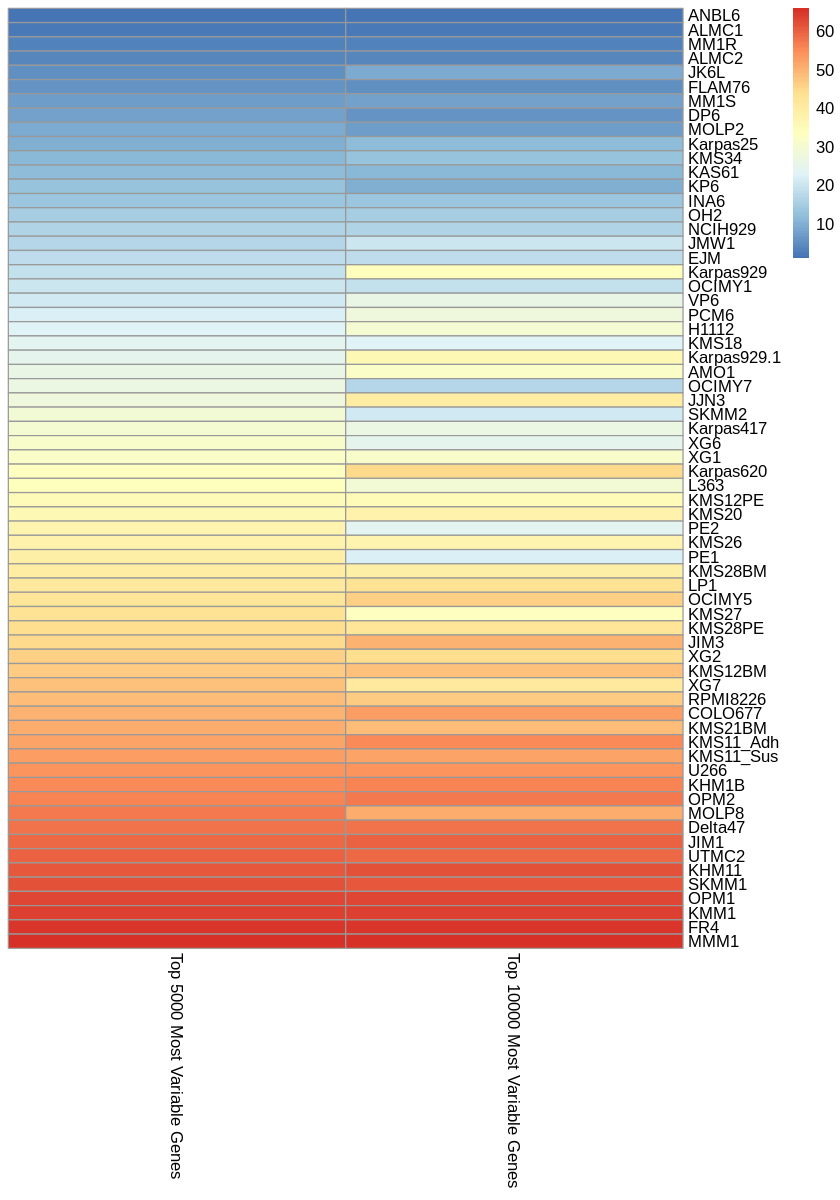

In [13]:
# making heatap of ranking differences

options(repr.plot.height = 10)
pheatmap(five10_bound, cluster_rows = FALSE, cluster_cols = FALSE)
options(repr.plot.height = 7)

In [14]:
# reading in Per Patient Visit File for info on progressive disease and others

MM_pat_ppv = data.frame(fread("MMRF_CoMMpass_IA13_PER_PATIENT_VISIT.csv"))

# getting list of patients annotated as having Progressive Disease

MM_pat_ppv_bool = MM_pat_ppv$AT_TREATMENTRESP %in% c('Progressive Disease')
MM_pat_pd = MM_pat_ppv[MM_pat_ppv_bool,]
MM_pat_pd_id = unique(MM_pat_pd$SPECTRUM_SEQ)
MM_pat_pd_id = MM_pat_pd_id[-1]
MM_pat_pd_id = paste(MM_pat_pd_id, '_BM', sep = '')

In [15]:
# pruning newly diagnosed data for paired wise boxplot w/ wilcoxon rank sum test

MM.cor.keats_5_nd_means2 = MM.cor.keats_5_nd_means_ranks
MM.cor.keats_5_nd_means2 = MM.cor.keats_5_nd_means2[-3]
MM.cor.keats_5_nd_means2$type = 'Newly Diagnosed'

# checking output head

head(MM.cor.keats_5_nd_means2)

# subsetting for patients with progressive disease and getting number of patients with progressive disease

MM.pd.bool = rownames(MM.cor.keats_5) %in% MM_pat_pd_id
MM.cor.keats_5_pd = MM.cor.keats_5[MM.pd.bool, ]
sum(MM.pd.bool)

# getting mean correlates for patients with progressive disease and labelling for boxplot

MM.cor.keats_5_pd = MM.cor.keats_5[MM.pd.bool, ]
MM.cor.keats_5_pd_means = data.frame(colMeans(MM.cor.keats_5_pd))
MM.cor.keats_5_pd_means$type = 'Progressive Disease'
colnames(MM.cor.keats_5_pd_means) = c('cor', 'type')
MM.cor.keats_5_pd_means = MM.cor.keats_5_pd_means[order(rownames(MM.cor.keats_5_pd_means)),]

# checking output head

head(MM.cor.keats_5_pd_means)

,cor,type
,<dbl>,<chr>
ALMC1,0.5066608,Newly Diagnosed
ALMC2,0.4967268,Newly Diagnosed
AMO1,0.4595980,Newly Diagnosed
ANBL6,0.5379676,Newly Diagnosed
COLO677,0.4367230,Newly Diagnosed
Delta47,0.4158869,Newly Diagnosed


[1] 81

,cor,type
,<dbl>,<chr>
ALMC1,0.5120027,Progressive Disease
ALMC2,0.5124982,Progressive Disease
AMO1,0.4814014,Progressive Disease
ANBL6,0.5435878,Progressive Disease
COLO677,0.4614933,Progressive Disease
Delta47,0.4313882,Progressive Disease


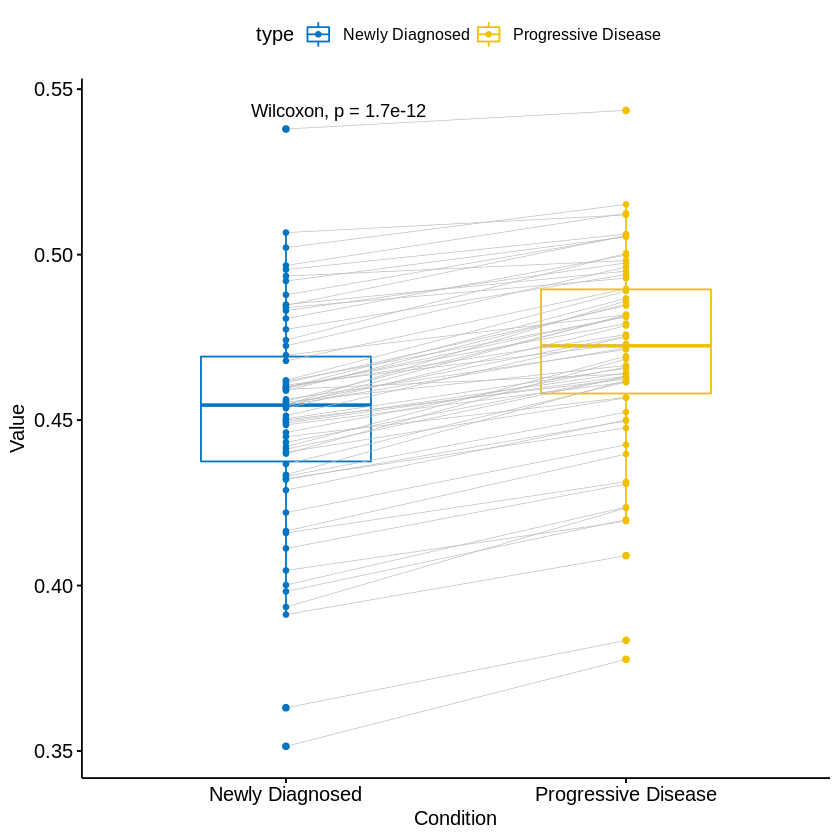

In [16]:
# fusing data frames by row for boxplot

pd_bound = rbind(MM.cor.keats_5_nd_means2, MM.cor.keats_5_pd_means)

# paired-wise boxplot comparing newly diagnosed and progressive disease patients

ggpaired(pd_bound, x = "type", y = "cor",
        color = "type", line.color = "gray", line.size = 0.2,
        palette = "jco")+
 stat_compare_means(paired = TRUE)

In [17]:

CCLE_cell_line = data.frame(fread("CCLE_RNAseq_genes_counts_20180929.gct"))
gid = CCLE_cell_line$Name
gid2 = substr(gid, 1, 15)
rownames(CCLE_cell_line) = gid2


CCLE_cell_line = CCLE_cell_line[-1]
CCLE_cell_line = CCLE_cell_line[-1]


CCLE_cell_line_meta = data.frame(fread("Cell_lines_annotations_20181226.txt"))
CCLE_cell_line_meta_2 = CCLE_cell_line_meta[(CCLE_cell_line_meta$type == 'multiple_myeloma'),]

CCLE_bool2 = colnames(CCLE_cell_line) %in% CCLE_cell_line_meta_2$CCLE_ID
CCLE_cell_line = CCLE_cell_line[,CCLE_bool2]
CCLE_cell_line = CCLE_cell_line[rownames(MM_combined.filtered),]
length(CCLE_cell_line[,1])
head(CCLE_cell_line)


CCLE_cell_names = c('AMO1', 'EJM', 'HUNS1',
                   'JJN3', 'Karpas620', 'KE97',
                   'KHM1B', 'KMM1', 'KMS11_Sus', 'KMS12BM',
                   'KMS18', 'KMS20', 'KMS21BM', 'KMS26', 'KMS27',
                   'KMS28BM', 'KMS34', 'L363', 'LP1', 'MM1S',
                   'MOLP2', 'MOLP8', 'NCIH929', 'OPM2',
                   'RPMI8226', 'SKMM2', 'U266')
colnames(CCLE_cell_line) = CCLE_cell_names

MM_combined_ccle.filtered = cbind(CCLE_cell_line, MM_patients)
MM_combined_ccle.filtered[is.na(MM_combined_ccle.filtered)] = 0
norm_CCLE_combined = vst(as.matrix(MM_combined_ccle.filtered))
norm_CCLE_combined_5 = norm_CCLE_combined[keepi5000, ]

[1] 22677

,AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,⋯,L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,LP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLP2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLP8_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH929_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OPM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,RPMI8226_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SKMM2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,U266B1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,56,642,15,17,204,13,4,7,14,24,⋯,16,30,22,26,27,26,14,29,16,31
ENSG00000000419,10884,7383,7458,5989,5646,9925,4271,5864,5662,7070,⋯,12073,9589,10297,7354,7369,42842,20907,5507,7197,3544
ENSG00000000457,2572,1482,2286,2691,1948,1876,2182,2068,2849,2044,⋯,4243,5365,3481,2653,3947,5933,3214,1439,1739,1797
ENSG00000000460,3844,2741,5379,3464,2487,2782,2757,2402,5753,4794,⋯,6044,1237,6129,1202,2375,4064,2694,2784,2183,2438
ENSG00000000938,3761,4,17,18,4547,13572,11348,42,2,9,⋯,62,5,20,397,29998,5497,3775,10,1288,369
ENSG00000000971,51,54,18,1617,36,62,11,155,27,12,⋯,18,47,44,31,1328,29,336,440,1044,41


converting counts to integer mode


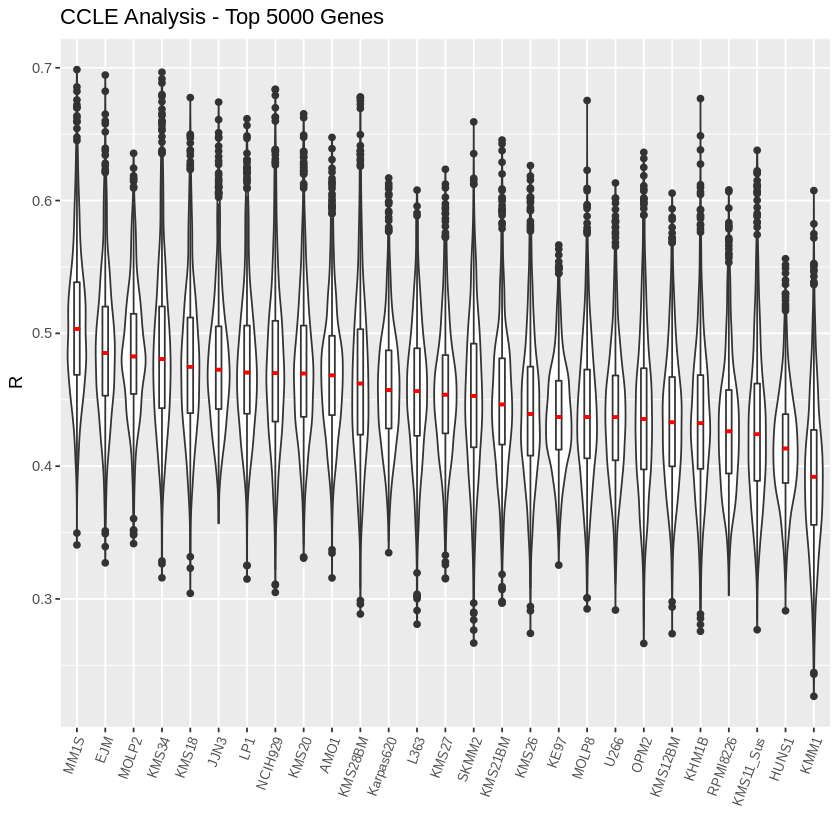

In [18]:
MM.cor.ccle_5 = cor(norm_CCLE_combined_5, method = "s")
makeplots(norm_CCLE_combined_5, colnames(MM_patients), 
          colnames(CCLE_cell_line), 'CCLE Analysis - Top 5000 Genes')

In [19]:
MM.cor.ccle_5_means = data.frame(colMeans((MM.cor.ccle_5[colnames(MM_patients_nd), CCLE_cell_names])))
MM.cor.ccle_5_means_ranks = MM.cor.ccle_5_means
MM.cor.ccle_5_means_ranks$type = 'CCLE'
colnames(MM.cor.ccle_5_means_ranks) = c('cor', 'type')
MM.cor.ccle_5_means_ranks = MM.cor.ccle_5_means_ranks[order(-MM.cor.ccle_5_means_ranks$cor),]


MM.cor.ccle_5_means_ranks = MM.cor.ccle_5_means_ranks[rownames(MM.cor.ccle_5_means_ranks) %in% colnames(MM_cell_line), ]
MM.cor.ccle_5_means_ranks$rank = c(1:length(MM.cor.ccle_5_means_ranks[,1]))
MM.cor.ccle_5_means_ranks = MM.cor.ccle_5_means_ranks[order(rownames(MM.cor.ccle_5_means_ranks)),]


MM.cor.keats_5_nd_means_ranks2 = MM.cor.keats_5_nd_means_ranks[rownames(MM.cor.keats_5_nd_means_ranks) %in% CCLE_cell_names,]
MM.cor.keats_5_nd_means_ranks2$type = 'Keats'
MM.cor.keats_5_nd_means_ranks2 = MM.cor.keats_5_nd_means_ranks2[order(-MM.cor.keats_5_nd_means_ranks2$cor),]
MM.cor.keats_5_nd_means_ranks2$rank = c(1:length(MM.cor.ccle_5_means_ranks[,1]))
MM.cor.keats_5_nd_means_ranks2 = MM.cor.keats_5_nd_means_ranks2[order(rownames(MM.cor.keats_5_nd_means_ranks2)),]

ggpaired(rbind(MM.cor.keats_5_nd_means_ranks2, MM.cor.ccle_5_means_ranks), x = "type", y = "cor",
        color = "type", line.color = "gray", line.size = 0.2,
        palette = "jco")+
 stat_compare_means(paired = TRUE)

ggpaired(rbind(MM.cor.keats_5_nd_means_ranks2, MM.cor.ccle_5_means_ranks), x = "type", y = "rank",
        color = "type", line.color = "gray", line.size = 0.2,`
        palette = "jco")+
 stat_compare_means(paired = TRUE)

# head(MM.cor.ccle_5_means_ranks)

ERROR: Error in parse(text = x, srcfile = src): <text>:25:62: unexpected INCOMPLETE_STRING
28: 
29: # head(MM.cor.ccle_5_means_ranks)
                                                                 ^


In [ ]:
cor.ccle.bound = cbind(MM.cor.keats_5_nd_means_ranks2, MM.cor.ccle_5_means_ranks)
cor.ccle.bound = cor.ccle.bound[-1]
cor.ccle.bound = cor.ccle.bound[-1]
cor.ccle.bound = cor.ccle.bound[-2]
cor.ccle.bound = cor.ccle.bound[-2]
colnames(cor.ccle.bound) = c('Keats', 'CCLE')
cor.ccle.bound = cor.ccle.bound[order(cor.ccle.bound$Keats),]
head(cor.ccle.bound)
pheatmap(cor.ccle.bound, cluster_rows = FALSE, cluster_cols = FALSE)